In [1]:
import wfdb
from wfdb import processing
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.fft import fft, ifft
from scipy import signal
import math
import seaborn as sns

def load_data(path):
    """Načte soubor databáze a vrátí vzorky signálu EKG a seznam polí"""
    try:
        signals, fields = wfdb.rdsamp(path)
        ecg = signals[:, 0].flatten()
        ecg = high_pass_filter(ecg, fields["fs"])
        return ecg, fields
    
    except Exception as e:
        print(f"Chyba při načítání dat: {e}")
        return None, None

def estimate_threshold(signal, perc=92):
    return np.percentile(signal, perc)

def high_pass_filter(signal, samp_rate, cutoff_freq=50):
    tau = 1 / (2 * np.pi * cutoff_freq)
    alpha = tau / (tau + 1 / (2 * np.pi * samp_rate))
    y_prev = 0
    x_prev = 0

    filtered_signal = []
    for x in signal:
        y = alpha * (y_prev + x - x_prev)
        filtered_signal.append(y)
        y_prev = y
        x_prev = x

    return np.array(filtered_signal)

def remove_baseline_wander_fft(ekg_data, sampling_rate=4, cutoff_frequency=0.5):
    """Odebere baseline wander pro lepší manipulaci s daty pomocí Fourierovy transformace
    k nalezení nízkofrekvenčních komponent a jejich odstranění."""
    spectrum = fft(ekg_data)
    freq = np.fft.fftfreq(len(ekg_data), 1 / sampling_rate)
    spectrum[(freq > -cutoff_frequency) & (freq < cutoff_frequency)] = 0
    ekg_without_baseline = np.real(ifft(spectrum))
    return ekg_without_baseline

def find_Rpeaks(signal):
    """Najde R píky v EKG signálu s dynamicky se měnící velikostí okna.
    Vrátí seznam píků a odpovídajících časů."""
    threshold = estimate_threshold(signal)
    peaks = []
    is_peak = False
    current_peak_value = -np.inf
    current_peak_index = 0

    for i, value in enumerate(signal):
        if value > threshold:
            if not is_peak or value > current_peak_value:
                current_peak_value = value
                current_peak_index = i
            is_peak = True
        else:
            if is_peak:
                peaks.append(current_peak_index)
                is_peak = False
    return np.array(peaks)

def count_rpeaks_in_windows(signal, r_peaks, samp_rate):
    """Počítá počet R píků každých 15 sekund"""
    signal_duration = len(signal) / samp_rate
    window_duration = 15.0
    window_count = int(signal_duration / window_duration)

    r_peak_counts = [0] * window_count

    for r_peak in r_peaks:
        window_index = int(r_peak / (samp_rate * window_duration))
        if 0 <= window_index < window_count:
            r_peak_counts[window_index] += 1

    return r_peak_counts

def preprocess_signals(signals, samp_rates):
    dominant_samp_rate = samp_rates[np.argmax(samp_rates)]

    synchronized_signals = []

    #resampling
    for i, (signal, samp_rate) in enumerate(zip(signals, samp_rates)):
        if samp_rate != dominant_samp_rate:
            isignal = scipy.signal.resample(signal, int(signal.size * (dominant_samp_rate / samp_rate)))
            signals[i] = isignal[:signal.size]

    #start from peak
    for i, (signal, samp_rate) in enumerate(zip(signals, samp_rates)):
        R_peaks_positions = find_Rpeaks(signal[:int(samp_rate)*2])
        if not R_peaks_positions.any():
            imax = np.argmax(signal[:int(samp_rate)*2])
            synchronized_signals.append(signal[imax:])
        else:
            synchronized_signal = signal[R_peaks_positions[0]:]
            synchronized_signals.append(synchronized_signal)

    #cropping to same length
    min_length = min([signal.size for signal in synchronized_signals])

    for i, (signal, size) in enumerate(zip(synchronized_signals, [s.size for s in synchronized_signals])):
        if size != min_length:
            synchronized_signals[i] = signal[:min_length]

    return synchronized_signals

def normalize_correlation(corr_fn):
    return corr_fn / np.max(np.abs(corr_fn))

def urci_korelaci_prumer_odchylky(database, x, y, signal_1, signal_2):
    mean_signal = np.mean(signal_1)
    mean_signal = np.mean(signal_2)
    std_signal = np.std(signal_1)
    std_signal = np.std(signal_2)

    print(f"Průměr prvního srovávaného signálu: {mean_signal}, Směrodatná odchylka: {std_signal}") 
    print(f"Průměr druhého srovávaného signálu: {mean_signal}, Směrodatná odchylka: {std_signal}")
    
def odezva_cross_corr(database, x, y, signal_1, signal_2):
    cross_corr = np.correlate(signal_1, signal_2, mode='full')
    lag = np.argmax(cross_corr) - len(signal_1) + 1
    print(f"Maximum cross-correlation mezi {database[x][9:]} a {database[y][9:]} se vyskytuje se zpožděním: {lag}")
    return lag, cross_corr


In [2]:
database = ["Database/drive{:02d}".format(i+1) for i in range(16)] + ["Database/drive17a", "Database/drive17b"]
signals = []
samps = []

size = 18

for i in range(size):
    ecg, fields = load_data(database[i])
    samp_rate = fields['fs']

    signals.append(remove_baseline_wander_fft(ecg, samp_rate))
    samps.append(samp_rate)

dominant_samp = samps[np.argmax(samps)]
print(dominant_samp)

31


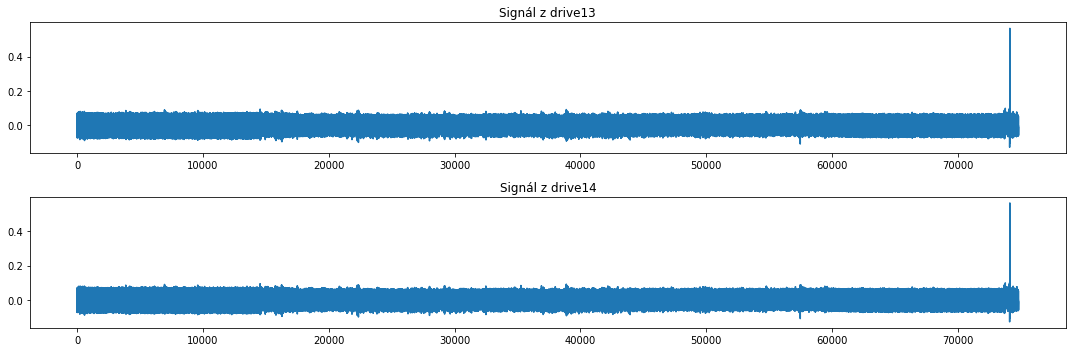

In [3]:
plt.figure(figsize=(15, 5))

# Zobrazit první signál
plt.subplot(2, 1, 1)
plt.plot(signals[12])  # Změňte index podle potřeby
plt.title(f"Signál z {database[12][9:]}")

# Zobrazit druhý signál
plt.subplot(2, 1, 2)
plt.plot(signals[13])  # Změňte index podle potřeby
plt.title(f"Signál z {database[13][9:]}")

plt.tight_layout()
plt.show()

In [6]:
from scipy.stats import pearsonr, spearmanr, kendalltau

urci_korelaci_prumer_odchylky(database, 12,13, signals[12], signals[13])
lag, cross_corr = odezva_cross_corr(database, 12,13, signals[12], signals[13])

corr_coefficient, p_value = pearsonr(signals[12], signals[13])
print(f"Pearsonův korelační koeficient: {corr_coefficient}, p-hodnota: {p_value}")

spearman_corr, spearman_p_value = spearmanr(signals[12], signals[13])
print(f"Spearmanův rangový korelační koeficient: {spearman_corr}, p-hodnota: {spearman_p_value}")

kendall_tau, kendall_p_value = kendalltau(signals[12], signals[13])
print(f"Kendallova tau: {kendall_tau}, p-hodnota: {kendall_p_value}")


Průměr signálu drive13: 1.7570693179625044e-20, Směrodatná odchylka: 0.0354660775358052
Průměr signálu drive14: 1.7570693179625044e-20, Směrodatná odchylka: 0.0354660775358052
Maximum cross-correlation mezi drive13 a drive14 se vyskytuje se zpožděním: 0
Pearsonův korelační koeficient: 1.0, p-hodnota: 0.0
Spearmanův rangový korelační koeficient: 1.0, p-hodnota: 0.0
Kendallova tau: 1.0, p-hodnota: 0.0


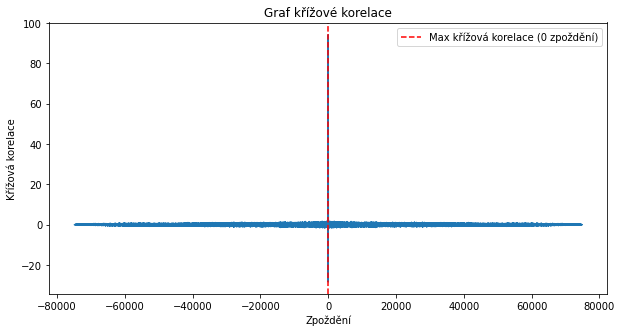

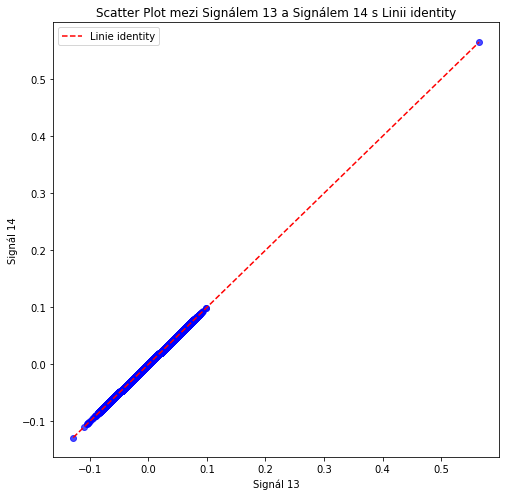

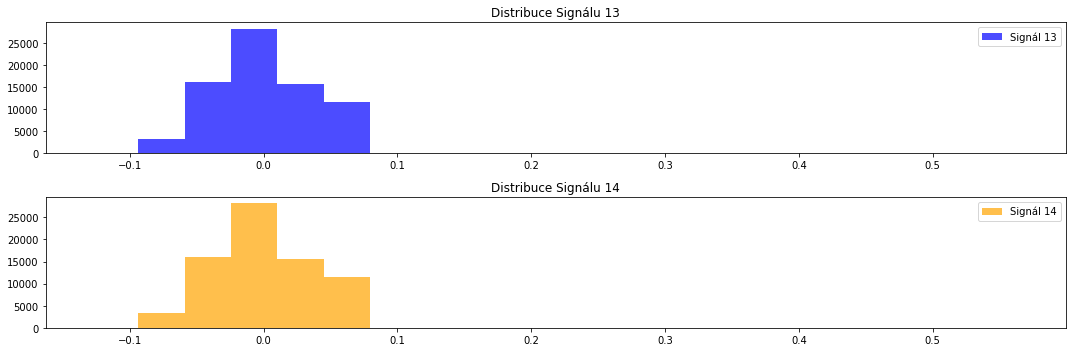

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(-len(signals[12])+1, len(signals[12])), cross_corr)
plt.title("Graf křížové korelace")
plt.xlabel("Zpoždění")
plt.ylabel("Křížová korelace")
plt.axvline(x=lag, color='red', linestyle='--', label=f'Max křížová korelace ({lag} zpoždění)')
plt.legend()
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(signals[12], signals[13], color='blue', alpha=0.7)
plt.plot([min(signals[12]), max(signals[12])], [min(signals[12]), max(signals[12])], linestyle='--', color='red', label='Linie identity')
plt.title("Scatter Plot mezi Signálem 13 a Signálem 14 s Linii identity")
plt.xlabel("Signál 13")
plt.ylabel("Signál 14")
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))

plt.subplot(2, 1, 1)
plt.hist(signals[12], bins=20, color='blue', alpha=0.7, label='Signál 13')
plt.title("Distribuce Signálu 13")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(signals[13], bins=20, color='orange', alpha=0.7, label='Signál 14')
plt.title("Distribuce Signálu 14")
plt.legend()

plt.tight_layout()
plt.show()


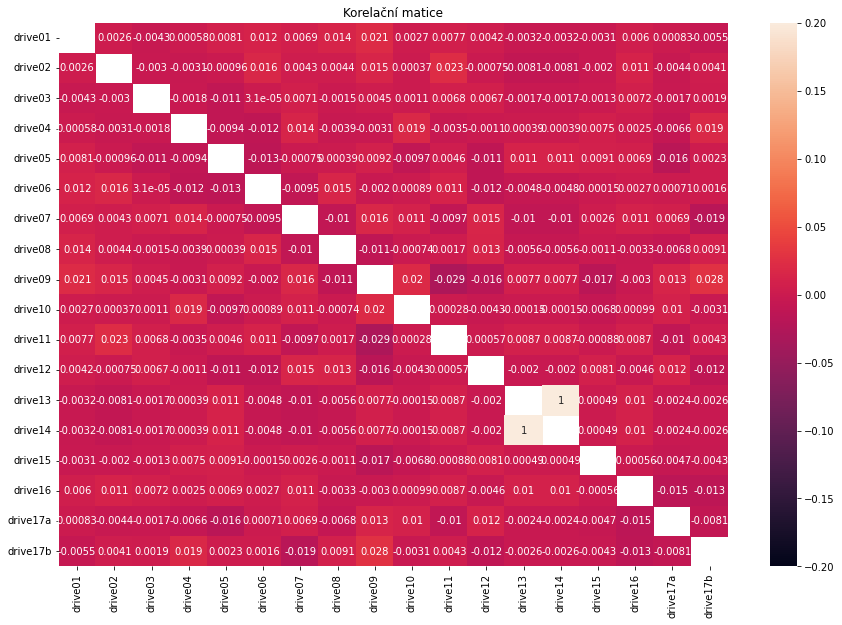

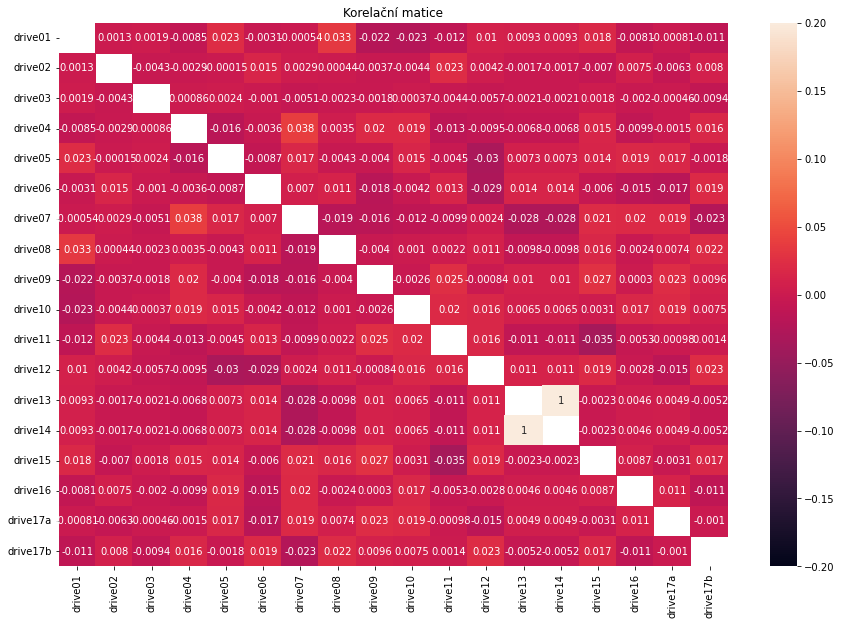

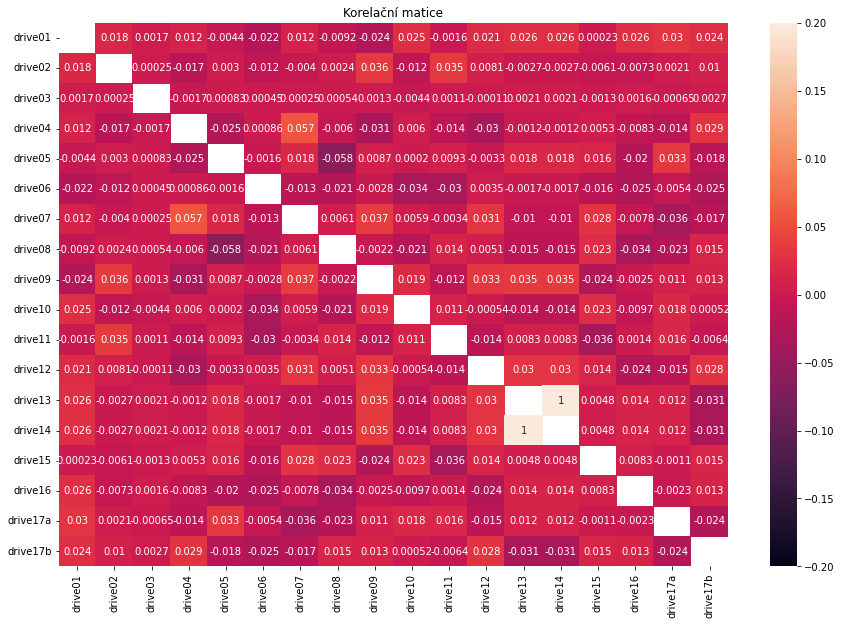

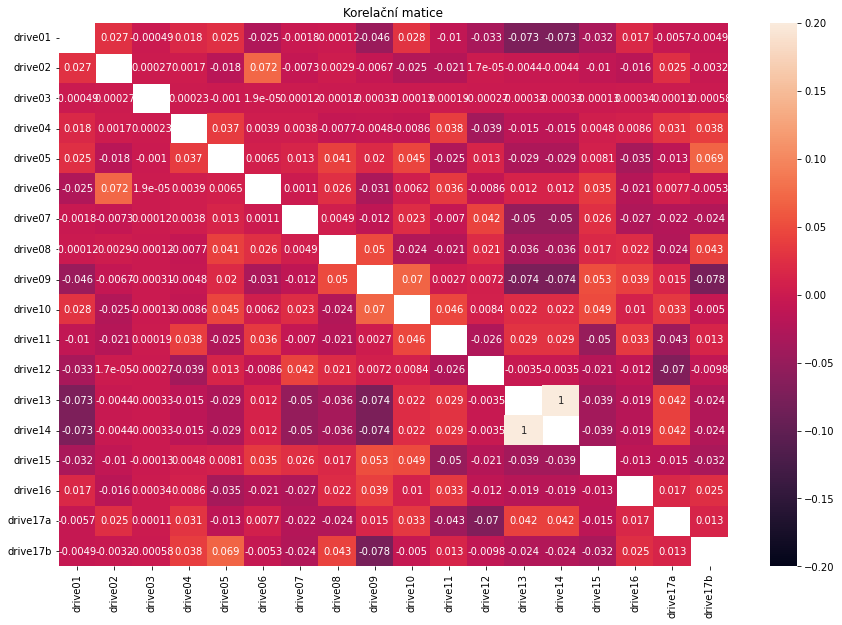

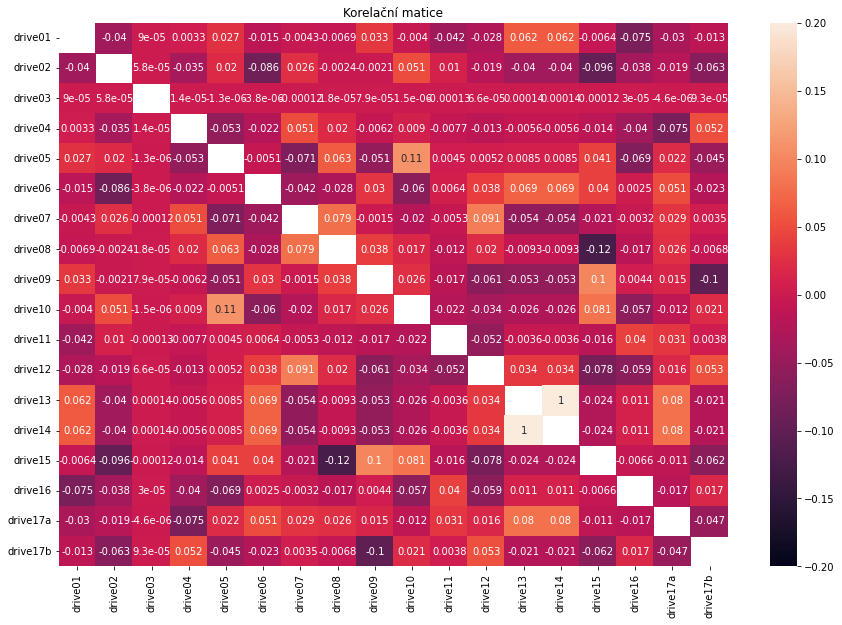

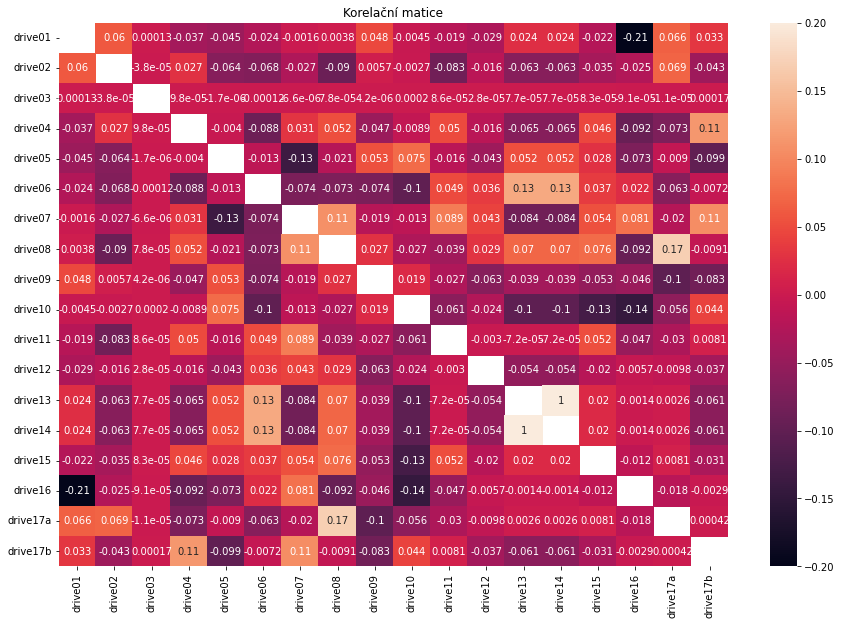

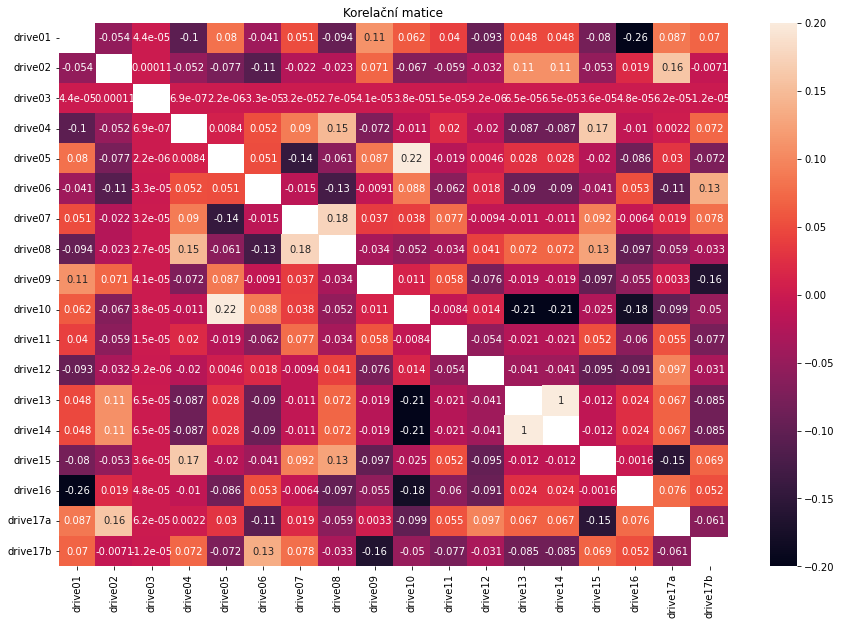

In [6]:
for i in range(0, 7):
    final_signals= preprocess_signals(signals, samps)

    data_as_list = [np.array(sublist) for sublist in final_signals]
    data_as_array = np.array(data_as_list)

    correlation_matrix = np.corrcoef(data_as_array)
    np.fill_diagonal(correlation_matrix, np.nan)

    plt.figure(figsize=(15,10))
    plt.title("Korelační matice")
    sns.heatmap(correlation_matrix, annot=True,
                xticklabels = [item[9:] for item in database[:size]],
                yticklabels = [item[9:] for item in database[:size]],
                vmin= -0.2, vmax= 0.2)
    plt.show()

In [7]:
imin = np.unravel_index(np.nanargmin(correlation_matrix), correlation_matrix.shape)
imax = np.unravel_index(np.nanargmax(correlation_matrix), correlation_matrix.shape)

vmin = np.nanmin(abs(correlation_matrix))
vmax = np.nanmax(abs(correlation_matrix))

min_labels = (database[imin[0]], database[imin[1]])
max_labels = (database[imax[0]], database[imax[1]])

print("Lowest value in correlation matrix:", vmin)
print("Corresponding labels:", min_labels)

print("\nHighest value in correlation matrix:", vmax)
print("Corresponding labels:", max_labels)

Lowest value in correlation matrix: 6.851802687532957e-07
Corresponding labels: ('Database/drive01', 'Database/drive16')

Highest value in correlation matrix: 1.0
Corresponding labels: ('Database/drive13', 'Database/drive14')


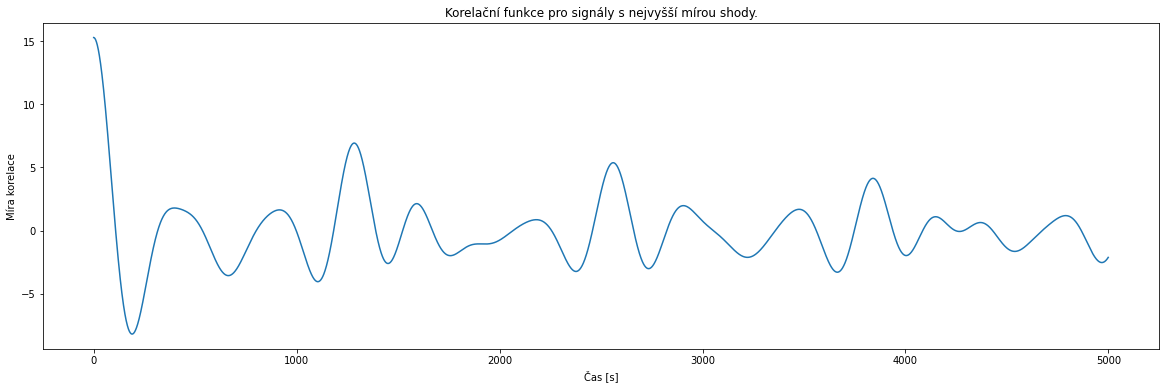

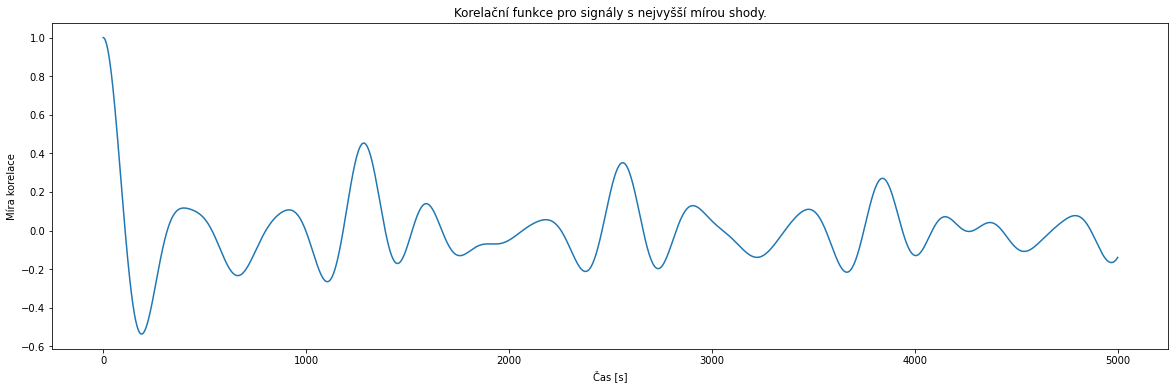

In [34]:
signal1 = data_as_array[12][:10000]
signal2 = data_as_array[13][:10000]

corr_fn = scipy.signal.correlate(signal1, signal2, mode="same")
corr_fn= np.array_split(corr_fn, 2)[1]

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejvyšší mírou shody.")
plt.plot(corr_fn)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.show()

normalized_corr_fn = normalize_correlation(corr_fn)

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejvyšší mírou shody.")
plt.plot(normalized_corr_fn)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.show()



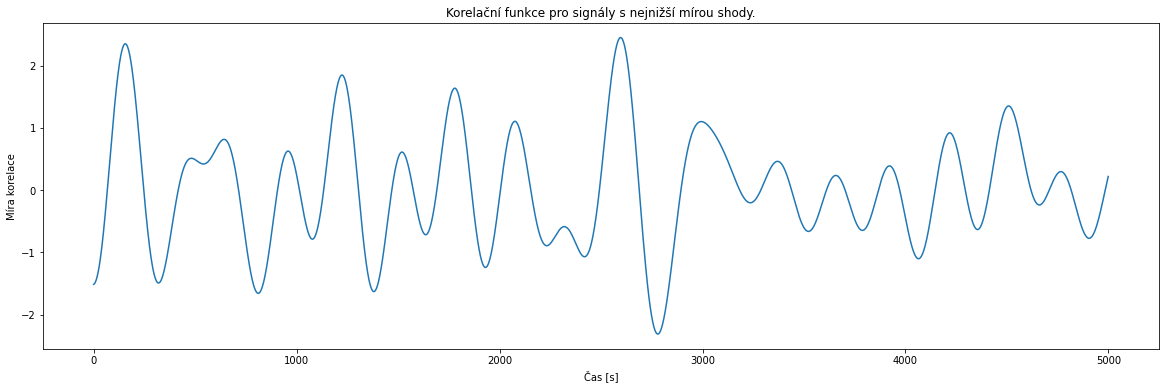

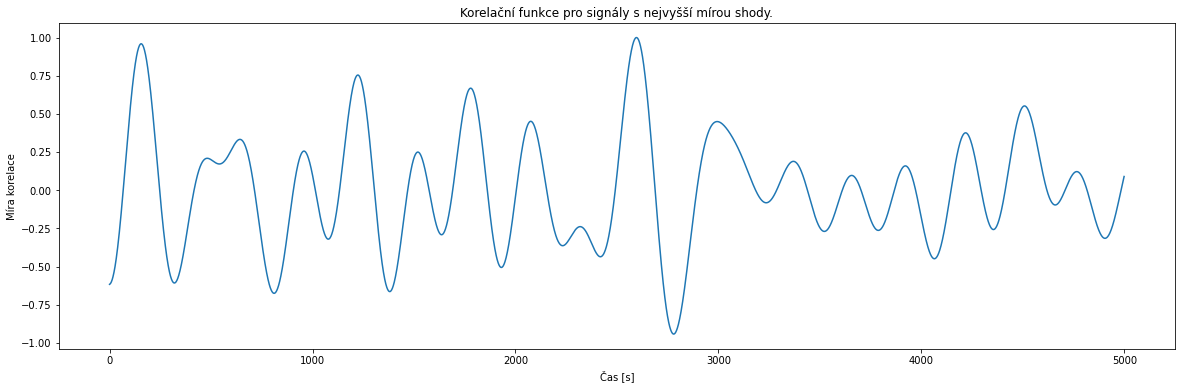

In [35]:
signal1 = data_as_array[0][:10000]
signal2 = data_as_array[15][:10000]

corr_fn = scipy.signal.correlate(signal1, signal2, mode="same")
corr_fn= np.array_split(corr_fn, 2)[1]

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejnižší mírou shody.")
plt.plot(corr_fn)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.show()


normalized_corr_fn = normalize_correlation(corr_fn)

plt.figure(figsize=(20,6))
plt.title("Korelační funkce pro signály s nejvyšší mírou shody.")
plt.plot(normalized_corr_fn)
plt.ylabel("Míra korelace")
plt.xlabel("Čas [s]")
plt.show()
